In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Energy estimation for classification

**Author(s):** Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

**Recommended datasample(s):** ``gamma-2`` (goes into classification training in the reference analysis since we use estimated energy as one of the model's features)

**Data level(s):** DL1b (telescope-wise image parameters) + DL2 (shower geometry + estimated energy)

**Description:**

This notebook contains benchmarks for the _protopipe_ pipeline regarding information from training data used for the training of the classification model.  

Only valid showers (meaning reconstructed with success) are considered.

**Requirements and steps to reproduce:**

This notebook requires a TRAINING file generated using ``protopipe-TRAINING``.  
The data format required to run the notebook is the current one used by _protopipe_ .

To get a filled notebook and reproduce these results,

- get the necessary input files using ``protopipe-TRAINING`` (see documentation)
- execute the notebook with ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n TRAINING/benchmarks_DL2_to_classification``

To obtain the list of all available parameters add ``--help-notebook``.

**Comparison against CTAMARS:**

- the input file needs to be a merged TRAINING file from the gamma2 sample
- reference simtel-files, plots, values and settings can be found [here (please, always refer to the latest version)](https://forge.in2p3.fr/projects/benchmarks-reference-analysis/wiki/Comparisons_between_pipelines).

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

## Table of contents
- [Energy dispersion](#Energy-dispersion)
- [Energy resolution and bias](#Energy-resolution-and-bias)
- [Migration energy matrix](#Migration-energy-matrix)

## Imports

In [2]:
from pathlib import Path

import tables
import astropy.units as u
import pandas
import numpy as np
from scipy.stats import binned_statistic
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import rc
import matplotlib.style as style
from cycler import cycler

from protopipe.pipeline.io import get_camera_names, read_protopipe_TRAINING_per_tel_type

# font size
font_size = 16

# Set general font size
plt.rcParams['font.size'] = font_size

## Functions

In [3]:
# TODO: move to protopipe.benchmarks.utils
def raise_(ex):
    """Raise an exception as a statement.
    
    This is a general purpose raiser for cases such as a lambda function.
    
    Parameters
    ----------
    ex: exception
        Python built-in exception to raise.
    """
    raise ex

# TODO: move to protopipe.benchmarks.utils
def string_to_boolean(variables):
    """Convert True/False strings to booleans.
    
    Useful in case a specific use of the CLI doesn't allow to read booleans as booleans.
    
    Parameters
    ----------
    variables: list of str
        Variables to check.
    """
    
    def check_str(x): return x if type(x) == bool \
        else True if x == "True" \
        else False if x == "False" \
        else raise_(ValueError(f"{x} is not a valid boolean."))
    
    return list(map(check_str, variables))

# TODO: move to protopipe.benchmarks.utils
def get_fig_size(ratio=None, scale=None):
    ratio = 4/3. if ratio is None else ratio
    scale = 1.0 if scale is None else scale
    height = 5
    width = height * ratio
    return (width*scale, height*scale)

## Input data

In [4]:
load_CTAMARS = False  # If True (default), compare to the CTAN analysis done with CTAMARS (Release 2019)
output_directory = Path.cwd() # default output directory for plots
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses" # path to 'analyses' folder inside 'shared_folder'
analysis_name = "v0.5.0a1" # Name of the analysis stored in 'analyses_folder'
input_filename = None # Name of the file produced with protopipe
CTAMARS_input_directory = None # Path to DL1 CTAMARS data (if load_CTAMARS_2019 is True)
mars_dl2b_energy_fileName = "CTA_4L15M_check_Erec.root" # Name of the CTAMARS reference file
use_seaborn = True
plots_scale = 1.0 # scale all figure sizes by a multiplicative factor

In [5]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
load_protopipe_previous = False
analysis_name_2 = "v0.4.0_dev1"
use_seaborn = True
matplotlib_settings = {
    "cmap": "cividis",
    "style": "seaborn-colorblind",
    "rc": {"font_size": 8, "font_family": "Fira Sans"},
    "scale": 1.5,
}
seaborn_settings = {
    "theme": {"style": "whitegrid", "context": "talk"},
    "rc_context": {},
    "rc_style": {"xtick.bottom": True, "ytick.left": True},
}
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_data_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": {
        "input_directory": "DL3",
        "input_file": "SubarrayLaPalma_4L15M_south_IFAE_50hours_20190630.root",
    },
    "label": "CTAMARS (2019)",
}
load_EventDisplay = True
input_data_EventDisplay = {
    "input_directory": "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203",
    "input_file": "CTA-Performance-North-20deg-S-50h_20181203.root",
    "label": "EventDisplay (2018)",
}
input_filenames = {
    "simtel": "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz",
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
model_configuration_filenames = {
    "energy": "RandomForestRegressor.yaml",
    "classification": "RandomForestClassifier.yaml",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
plots_scale = "1.5"
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/TRAINING"


In [6]:
# Handle boolean variables (papermill reads them as strings)
[load_CTAMARS, use_seaborn] = string_to_boolean([load_CTAMARS, use_seaborn])

In [7]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

In [8]:
# Plot aesthetics settings

scale = matplotlib_settings["scale"] if plots_scale is None else float(plots_scale)

style.use(matplotlib_settings["style"])
cmap = matplotlib_settings["cmap"]
rc('font', size=matplotlib_settings["rc"]["font_size"])

if matplotlib_settings["style"] == "seaborn-colorblind":
    
    # Change color order to have first ones more readable
    colors_order = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#56B4E9', '#F0E442']
    rc('axes', prop_cycle=cycler(color=colors_order))

if use_seaborn:
    import seaborn as sns
    
    sns.set_theme(context=seaborn_settings["theme"]["context"] if "context" in seaborn_settings["theme"] else "talk",
                  style=seaborn_settings["theme"]["style"] if "style" in seaborn_settings["theme"] else "whitegrid",
                  palette=seaborn_settings["theme"]["palette"] if "palette" in seaborn_settings["theme"] else None,
                  font=seaborn_settings["theme"]["font"] if "font" in seaborn_settings["theme"] else "Fira Sans",
                  font_scale=seaborn_settings["theme"]["font_scale"] if "font_scale" in seaborn_settings["theme"] else 1.0,
                  color_codes=seaborn_settings["theme"]["color_codes"] if "color_codes" in seaborn_settings["theme"] else True
                  )
    
    sns.set_style(seaborn_settings["theme"]["style"], rc=seaborn_settings["rc_style"])
    sns.set_context(seaborn_settings["theme"]["context"],
                    font_scale=seaborn_settings["theme"]["font_scale"] if "font_scale" in seaborn_settings["theme"] else 1.0)

### protopipe

In [9]:
if not input_filename:
    try:
        input_filename = input_filenames["TRAINING_classification_gamma"]
    except (NameError, KeyError):
        input_filename = "TRAINING_classification_tail_gamma_merged.h5"

In [10]:
input_directory = Path(analyses_directory) / analysis_name / Path("data/TRAINING/for_particle_classification/gamma")
cameras = get_camera_names(input_directory = input_directory, file_name = input_filename)
data = read_protopipe_TRAINING_per_tel_type(input_directory = input_directory,
                                            file_name = input_filename,
                                            camera_names=cameras)       

In [11]:
# select only successfully reconstructed showers
valid_showers = {}
for camera in cameras:
    valid_showers[camera] = data[camera][(data[camera]["is_valid"]==True)]

In [12]:
# then merge the tables
for i, camera in enumerate(cameras):
    if i==0:
        all_valid_showers = valid_showers[camera]
    else:
        all_valid_showers = all_valid_showers.append(valid_showers[camera])
# Finally drop duplicate showers (stereo information is the same for each event ID)
unique_all_valid_showers = all_valid_showers.drop_duplicates(subset=['event_id'])

In [13]:
true_energy = unique_all_valid_showers["true_energy"].values # TeV
reco_energy = unique_all_valid_showers["reco_energy"].values # TeV

### CTAMARS

In [14]:
if load_CTAMARS:
    
    # Get input file path
    if not CTAMARS_input_directory:
        try:
            CTAMARS_input_directory = Path(input_data_CTAMARS["parent_directory"]) / Path(input_data_CTAMARS["TRAINING/DL2"])
        except (NameError, KeyError):
            print("WARNING: CTAMARS data undefined! Please, check the documentation of protopipe-BENCHMARKS.")
    
    path_mars_dl2b_energy = CTAMARS_input_directory / Path(mars_dl2b_energy_fileName)

    with uproot.open(path_mars_dl2b_energy) as CTAMARS:
        CTAMARS_H = CTAMARS["Erec_over_E_vs_E"]
        CTAMARS_Eres = CTAMARS["Eres"]

    bin_edges_x = CTAMARS_H.member("fXaxis").edges()
else:
    bin_edges_x = np.arange(-1.9, 2.3 + 0.2, 0.2)

bin_edges_y = np.linspace(-1,2,200)
bin_centers_x = 0.5 * (bin_edges_x[1:]+bin_edges_x[:-1])

## Energy dispersion
[back to top](#Table-of-contents)

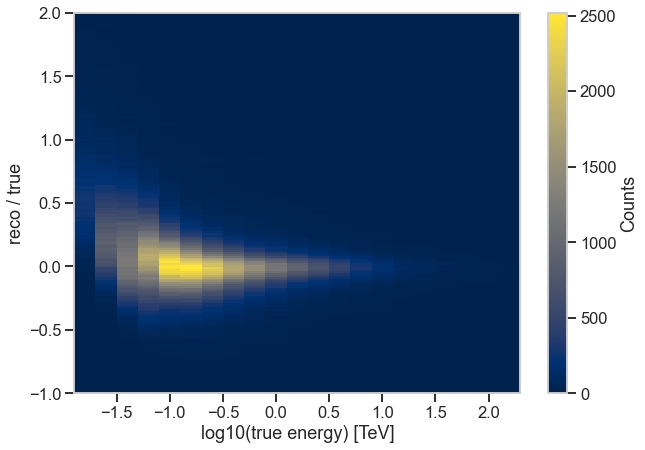

In [15]:
plt.figure(figsize=(10,7))

plt.hist2d(np.log10(true_energy),
           reco_energy/true_energy -1,
           bins=[bin_edges_x, bin_edges_y],
           cmap=cmap)

plt.grid(which="both", axis="both")
plt.colorbar(label='Counts')
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('reco / true')

plt.savefig(plots_folder / f"energy_dispersion_to_classification_protopipe_{analysis_name}.png")

plt.show()

None # to remove clutter by mpl objects

Same, but with a Y-axis normalization to ensure that the integral probability of reconstructing a photon with a certain true energy at a certain reconstructed energy is 1.0

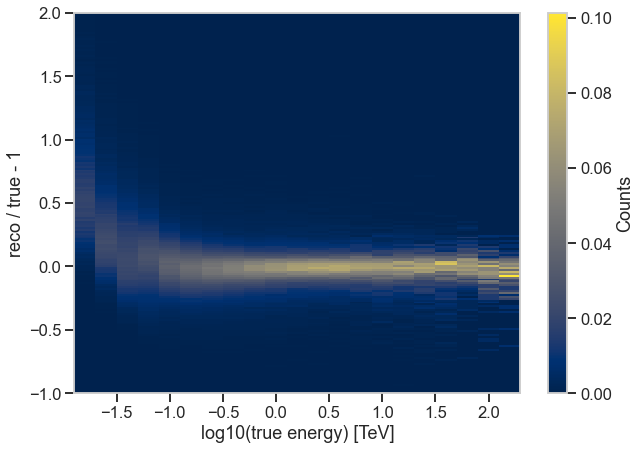

In [16]:
plt.figure(figsize=(10,7))

h, _, _ = np.histogram2d(np.log10(true_energy),
                         reco_energy/true_energy - 1,
                         bins=[bin_edges_x, bin_edges_y])
# normalize y-axis so to get a max probability of 1 within 1 bin in true energy
h = h/np.sum(h, axis=1)[np.newaxis].T
# re-plot
plt.pcolormesh(bin_edges_x, bin_edges_y, h.T, cmap=cmap)

plt.grid(which="both", axis="both")
plt.colorbar(label='Counts')
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('reco / true - 1')

plt.savefig(plots_folder / f"energy_dispersion_normalized_to_classification_protopipe_{analysis_name}.png")

plt.show()

None # to remove clutter by mpl objects

## Energy resolution and bias
[back to top](#Table-of-contents)

Considering the distribution,

``x = (E_reco / E_true) - 1``

**Energy bias** as the ``mean of x``, also in bins of true energy.We plot the **bias** as the ``mean of (Erec/Etrue-1)``, also in bins of true energy.

**Energy resolution** is here calculated in bins of true energy
- as the ``68%-quantile of the distribution of abs(x)``. 

Note that by using this definition, any possible reconstruction bias is "absorbed" in the resolution.

- as the same quantity, but bias-corrected as ``68%-quantile of the distribution of abs(x - bias)``

In [17]:
resolution = binned_statistic(np.log10(true_energy),
                          reco_energy/true_energy - 1,
                          statistic = lambda x: np.percentile(np.abs(x), 68),
                          bins=bin_edges_x)

corr_resolution_mean = binned_statistic(np.log10(true_energy),
                              reco_energy/true_energy - 1,
                              statistic = lambda x: np.percentile(np.abs(x-np.mean(x)), 68),
                              bins=bin_edges_x)

corr_resolution_median = binned_statistic(np.log10(true_energy),
                              reco_energy/true_energy - 1,
                              statistic = lambda x: np.percentile(np.abs(x-np.median(x)), 68),
                              bins=bin_edges_x)

bias_mean = binned_statistic(np.log10(true_energy), 
                    reco_energy/true_energy - 1, 
                    statistic="mean", 
                    bins=bin_edges_x)

bias_median = binned_statistic(np.log10(true_energy), 
                    reco_energy/true_energy - 1, 
                    statistic="median", 
                    bins=bin_edges_x)

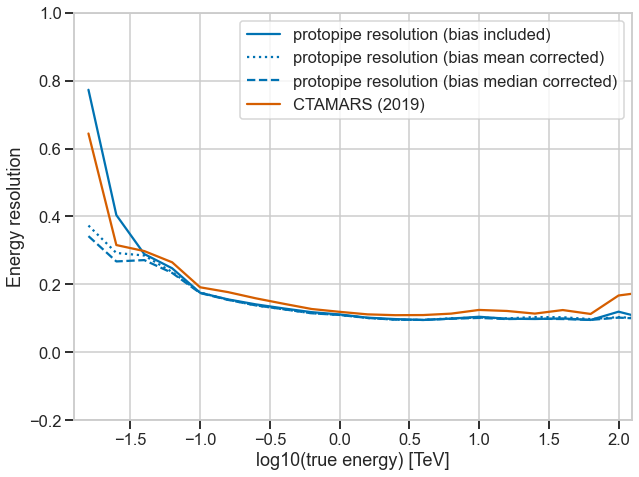

In [18]:
fig = plt.figure(figsize=get_fig_size(ratio=4/3., scale=scale))

if load_CTAMARS:
    
    res = plt.plot(bin_centers_x, resolution[0], label="protopipe resolution (bias included)")
    resolution_color = res[0].get_color()
    plt.plot(bin_centers_x, corr_resolution_mean[0], label="protopipe resolution (bias mean corrected)", color=resolution_color, ls = "dotted")
    plt.plot(bin_centers_x, corr_resolution_median[0], label="protopipe resolution (bias median corrected)", color=resolution_color, ls="dashed")
    
    plt.plot(bin_centers_x, CTAMARS_Eres.members["fY"], label=input_data_CTAMARS["label"])
    
    plt.grid(which="both", axis="both")
    plt.xlabel('log10(true energy) [TeV]')
    plt.ylabel('Energy resolution')
    plt.xlim(-2.1, 2.1)
    plt.ylim(-0.2, 1.0)
    plt.legend(loc="best")
    plt.grid(which="both", visible=True)

    plt.savefig(plots_folder / f"energy_resolution_bias_CTAMARS_comparison_protopipe_{analysis_name}.png")
    None # to remove clutter by mpl objects

else:
    res = plt.plot(bin_centers_x, resolution[0], label="resolution (bias included)")

    resolution_color = res[0].get_color()
    plt.plot(bin_centers_x, corr_resolution_mean[0], label="resolution (bias mean corrected)", color=resolution_color, ls = "dotted")
    plt.plot(bin_centers_x, corr_resolution_median[0], label="resolution (bias median corrected)", color=resolution_color, ls="dashed")

plt.legend()
plt.grid(which="both", visible=True)
plt.ylim(-0.2, 1.0)
plt.xlim(np.log10(0.0125), np.log10(125))
plt.xlabel('log10(true energy) [TeV]')

plt.savefig(plots_folder / f"energy_resolution_protopipe_{analysis_name}.png")
None # to remove clutter by mpl objects

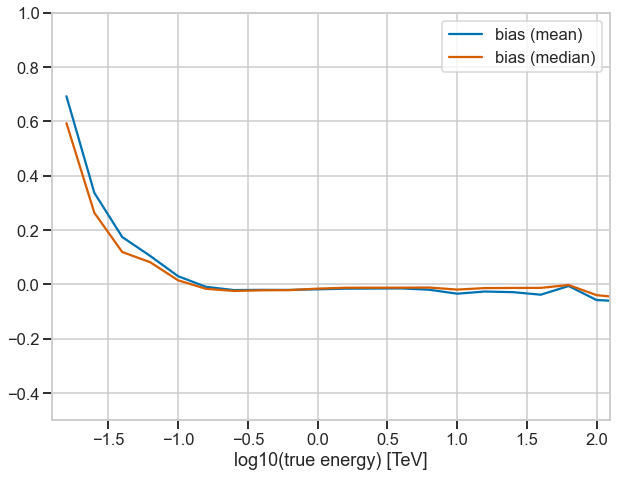

In [19]:
fig = plt.figure(figsize=get_fig_size(ratio=4/3., scale=scale))

plt.plot(bin_centers_x, bias_mean[0], label="bias (mean)")
plt.plot(bin_centers_x, bias_median[0], label="bias (median)")
plt.legend()
plt.grid(which="both", visible=True)
plt.ylim(-0.5, 1.0)
plt.xlim(np.log10(0.0125), np.log10(125))
plt.xlabel('log10(true energy) [TeV]')

plt.savefig(plots_folder / f"energy_bias_protopipe_{analysis_name}.png")
None # to remove clutter by mpl objects

Now we can superimpose these benchmarks to the normalized energy dispersion around 1.  
The error bars correspond to the bias-corrected resolution.

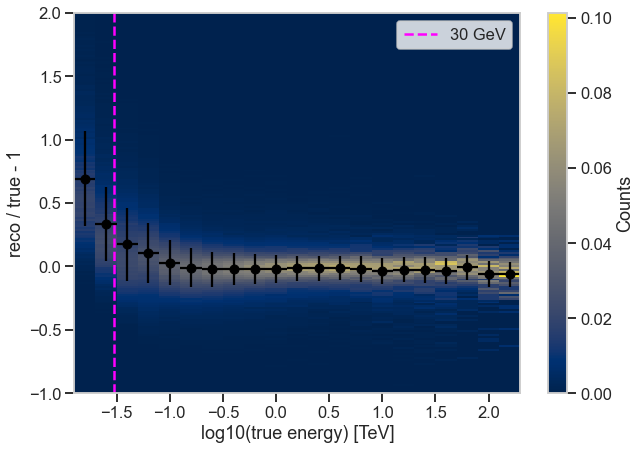

In [20]:
plt.figure(figsize=(10,7))

h, _, _ = np.histogram2d(np.log10(true_energy),
                         (reco_energy/true_energy) -1,
                         bins=[bin_edges_x, bin_edges_y])
# normalize y-axis so to get a max probability of 1 within 1 bin in true energy
h = h/np.sum(h, axis=1)[np.newaxis].T
# re-plot
plt.pcolormesh(bin_edges_x, bin_edges_y, h.T, cmap=cmap)


corr_resolution = binned_statistic(np.log10(true_energy),
                                  (reco_energy/true_energy) -1,
                                  statistic = lambda x: np.percentile(np.abs(x-np.mean(x)), 68),
                                  bins=bin_edges_x)

bias = binned_statistic(np.log10(true_energy), 
                        (reco_energy/true_energy) -1, 
                        statistic="mean", 
                        bins=bin_edges_x)

plt.errorbar(x = bin_centers_x,
             y = bias[0],
             xerr = np.diff(bin_edges_x)/2,
             yerr = corr_resolution[0],
             ls="none",
             fmt = "o",
            color="black")

plt.vlines(np.log10(0.03),
           plt.gca().get_ylim()[0],
           plt.gca().get_ylim()[1],
           ls="--",
           lw=2.5,
           color="magenta",
           label="30 GeV")

plt.grid(which="both", axis="both")
plt.colorbar(label='Counts')
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('reco / true - 1')
plt.legend()

plt.savefig(plots_folder / f"energy_resolution_bias_over_normalized_dispersion_to_classification_protopipe_{analysis_name}.png")

None # to remove clutter by mpl objects

## Migration energy matrix
[back to top](#Table-of-contents)

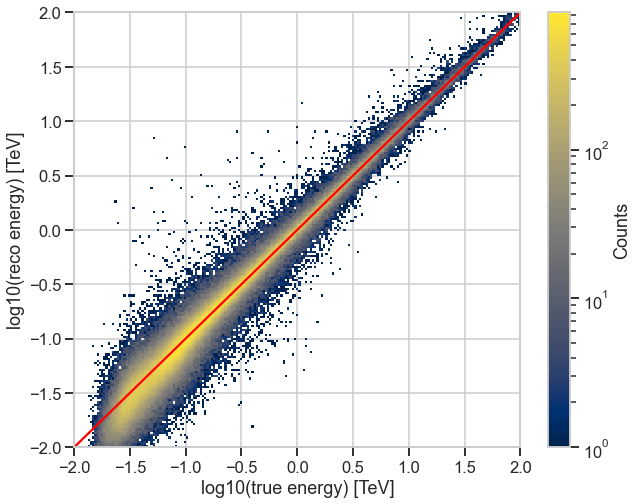

In [21]:
plt.figure(figsize=(10,8))

bin_edges = np.linspace(-2,2,200)

plt.hist2d(np.log10(reco_energy),
           np.log10(true_energy),
           bins=[bin_edges, bin_edges],
           norm=LogNorm(),
           cmap=cmap)
plt.plot(bin_edges, bin_edges, color="red")
plt.grid(which="both", axis="both")
plt.colorbar(label='Counts', ax=plt.gca())

plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('log10(reco energy) [TeV]')

plt.savefig(plots_folder / f"migration_energy_matrix_to_classification_protopipe_{analysis_name}.png")

None # to remove clutter by mpl objects